In [45]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [46]:
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X

# for each subject make a large array of copipes of the x data where each muscle is deleted systematically and then the data is appeneded together
# this will be the input data

def augment_subject_data(subject_df):
    x_cols = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Fx', 'Fy', 'Fz']
    y_cols = ['Pain_Cohort', 'Eaton_Litter']
    muscles = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB']
    # check which muscles are non-zero
    used_muscles = []
    for muscle in muscles:
        if subject_df[muscle].sum() != 0:
            used_muscles.append(muscle)
    # for each muscle that is non-zero, delete it and append the data to a list
    # copy the df so that we don't overwrite it
    subject_df_copy = subject_df.copy()
    # make a list to store the data
    x_data = []
    x_original = []
    y_data = []
    for muscle in used_muscles:
        # delete the muscle
        subject_df_copy[muscle] = 0
        # append the data
        # sort by the Frame column
        subject_df_copy = subject_df_copy.sort_values(by=['Frame'])
        x_data.append(subject_df_copy[x_cols].values.reshape(1, -1))
        y_data.append(subject_df_copy[y_cols].values[0,:])
        # append the original data
        x_original.append(subject_df[x_cols].values.reshape(1, -1))
        # reset the df
        subject_df_copy = subject_df.copy()
    # return the data
    return np.row_stack(x_data), np.row_stack(x_original), np.row_stack(y_data)

def augment2(df):
    # pass all the data through augmenter again
    x_data = []
    y_data = []
    x_og_data = []
    subject_dfs = df.groupby(['Subject','Event'])
    # copy the df so that we don't overwrite it
    # for each subject, zero one muscle at a time and append the data
    for subject, subject_df in subject_dfs:
        subject_df_copy = subject_df.copy()
        # pick a random muscle
        muscle = np.random.choice(['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB'])
        # zero the muscle
        subject_df_copy[muscle] = 0
        # augment the data
        x, x_og, y = augment_subject_data(subject_df)
        # append the data
        x_data.append(x)
        y_data.append(y)
        x_og_data.append(x_og)
        # reset the df
        subject_df_copy = df.copy()
    # stack the data
    x_data = np.row_stack(x_data)
    y_data = np.row_stack(y_data)
    x_og_data = np.row_stack(x_og_data)
    return x_data, x_og_data, y_data


In [47]:
df = pd.read_pickle('./data/ML_Data.pkl')
df.columns

Index(['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP',
       'FPB', 'Subject', 'Event', 'Frame', 'Pain_Cohort', 'Eaton_Litter'],
      dtype='object')

In [48]:
subjects = df['Subject'].unique()
# get dfs by subject and event
groups_subject = df.groupby(['Subject', 'Event'])
# for each group get the dataframe 
subject_dfs = []
for name, group in groups_subject:
    subject_dfs.append(group)
subject_df = subject_dfs[0]

In [49]:
# test
x, x_og, y = augment_subject_data(subject_df)
# get all the augmented data
x_data = []
x_og_data = []
y_data = []
for subject_df in subject_dfs:
    x, x_og, y = augment_subject_data(subject_df)
    x_data.append(x)
    x_og_data.append(x_og)
    y_data.append(y)
# stack the data
# loop through the subjects and augment the data and append it to the data
for subject_df in subject_dfs:
    x, x_og, y = augment2(subject_df)
    x_data.append(x)
    y_data.append(y)
    x_og_data.append(x_og)
# stack the data
x_data = np.row_stack(x_data)
y_data = np.row_stack(y_data)
x_og_data = np.row_stack(x_og_data)
X = to_torch(x_data)
Y = to_torch(y_data)
X_og = to_torch(x_og_data)
X.shape, Y.shape, X_og.shape

(torch.Size([660, 11000]), torch.Size([660, 2]), torch.Size([660, 11000]))

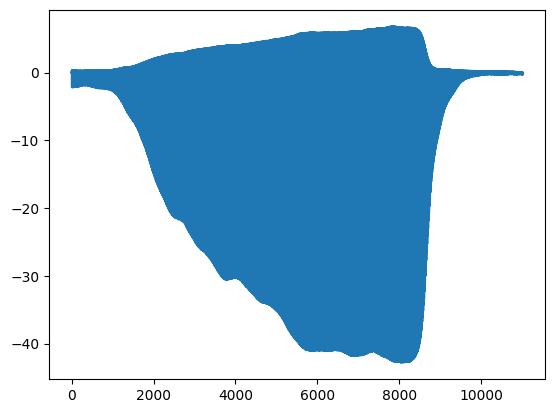

In [50]:
plt.plot(X_og[0, :])

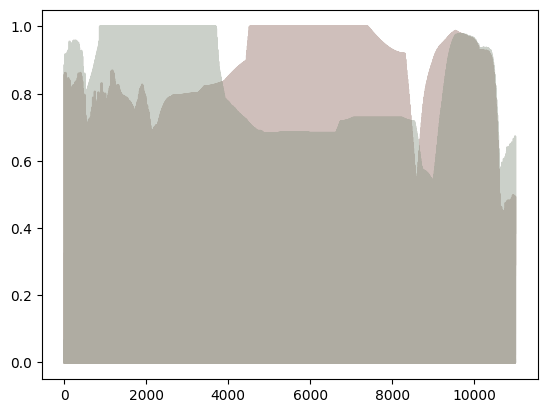

In [51]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_og = scaler.transform(X_og)
X = to_torch(X)
X_og = to_torch(X_og)
plt.plot(X_og[0:10, :].T, alpha=0.1)

(array([228.,   0.,   0., 156.,   0.,   0., 150.,   0.,   0., 126.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

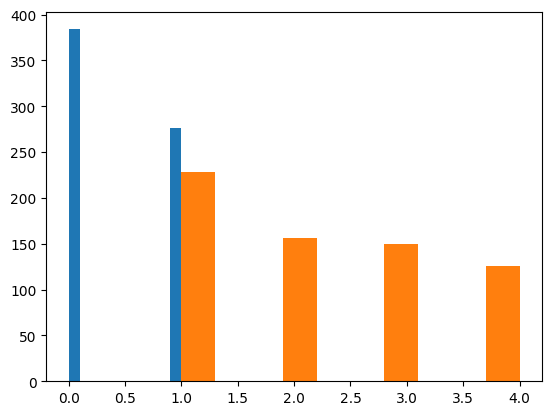

In [52]:
plt.hist(Y[:,0])
plt.hist(Y[:,1])

In [53]:
# plot the latent space of the un-augmented data
def get_data(df):
    x_cols = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Fx', 'Fy', 'Fz']
    y_cols = ['Pain_Cohort', 'Eaton_Litter']
    groups = df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        X.append(group[x_cols].values.reshape(1, -1))
        Y.append(group[y_cols].values[0,:])
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

X_prime, Y_prime = get_data(df)
X_prime = scaler.transform(X_prime)
X_prime.shape, Y_prime.shape

((60, 11000), (60, 2))

In [54]:
X = to_torch(X)
Y = to_torch(Y)
X_prime = to_torch(X_prime)
Y_prime = to_torch(Y_prime)

X = torch.cat((X, X_prime), dim=0)
Y = torch.cat((Y, Y_prime), dim=0)
X_og = torch.cat((X_og, X_prime), dim=0)
X.shape, Y.shape

(torch.Size([720, 11000]), torch.Size([720, 2]))

In [55]:
import lovely_tensors as lt
lt.monkey_patch()

In [56]:
X.v

tensor[720, 11000] n=7920000 (30Mb) x∈[-5.925e-08, 1.000] μ=0.340 σ=0.337
tensor([[0.0000e+00, 0.0000e+00, 2.0397e-01,  ..., 2.0169e-01, 4.9340e-01,
         2.9222e-01],
        [0.0000e+00, 3.2162e-01, 0.0000e+00,  ..., 2.0169e-01, 4.9340e-01,
         2.9222e-01],
        [0.0000e+00, 3.2162e-01, 2.0397e-01,  ..., 2.0169e-01, 4.9340e-01,
         2.9222e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 1.2227e-04,  ..., 4.9017e-01, 8.0860e-01,
         3.1137e-01],
        [0.0000e+00, 0.0000e+00, 4.7545e-05,  ..., 6.3158e-01, 8.4222e-01,
         3.8652e-01],
        [0.0000e+00, 0.0000e+00, 2.7501e-05,  ..., 7.2721e-01, 8.2448e-01,
         3.9728e-01]])

In [59]:
config = {
    'estimator_type': 'VAE',
    'n_inputs': X.shape[1],
    'n_outputs': X.shape[1],
    'input_dim': X.shape[1],
    'is_VAE': True,
    'batch_size':256, 
    'epochs':1001, 
    'verbose':10,
    'latent_dim': 2,
    'lr_init':5e-3,
    'reg_factor':0,
    'n_layers':2,
    'hidden_dim':50,
    'beta':10,
}
reg = kmk.Trainer(**config)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# lets use parameter sampler from sklearn so that we don't have to use the CV part of RandomizedSearchCV
from scipy.stats import uniform, randint
param_space = {'lr_init':[1e-3, 1e-4, 1e-5],
               'n_layers':[ 2, 3], 
               'hidden_dim':[32, 64, 128, 256, 512],
}
param_space, reg.config

({'lr_init': [0.001, 0.0001, 1e-05],
  'n_layers': [2, 3],
  'hidden_dim': [32, 64, 128, 256, 512]},
 {'n_inputs': 11000,
  'n_outputs': 11000,
  'input_dim': 11000,
  'is_VAE': True,
  'batch_size': 256,
  'epochs': 1001,
  'verbose': 10,
  'latent_dim': 2,
  'lr_init': 0.005,
  'reg_factor': 0,
  'n_layers': 2,
  'hidden_dim': 50,
  'beta': 10,
  'metric': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>,
  'lr_gamma': 0.1,
  'scheduler': kmodels.utils.LR_scheduler,
  'device': 'cpu',
  'binary_dim': 0,
  'gamma': 0,
  'binary_dim_y': 0})

In [60]:
reg = kmk.Trainer(**config)
reg.estimator(X)[0].shape
reg.fit(X, X_og)


====> Epoch: 0 Average loss: 534504.937500000 Time: 1.81
Loss components: {'VAE_loss': tensor 5.268e+05, 'L1_regularization': tensor grad MulBackward0 7.751e+03}
====> Epoch: 10 Average loss: 182103.296875000 Time: 1.46
Loss components: {'VAE_loss': tensor 1.748e+05, 'L1_regularization': tensor grad MulBackward0 7.293e+03}
====> Epoch: 20 Average loss: 171018.703125000 Time: 1.50
Loss components: {'VAE_loss': tensor 1.655e+05, 'L1_regularization': tensor grad MulBackward0 5.540e+03}
====> Epoch: 30 Average loss: 163766.468750000 Time: 1.47
Loss components: {'VAE_loss': tensor 1.598e+05, 'L1_regularization': tensor grad MulBackward0 3.999e+03}
====> Epoch: 40 Average loss: 149427.640625000 Time: 1.48
Loss components: {'VAE_loss': tensor 1.469e+05, 'L1_regularization': tensor grad MulBackward0 2.538e+03}
====> Epoch: 50 Average loss: 137933.203125000 Time: 1.47
Loss components: {'VAE_loss': tensor 1.364e+05, 'L1_regularization': tensor grad MulBackward0 1.553e+03}
====> Epoch: 60 Average

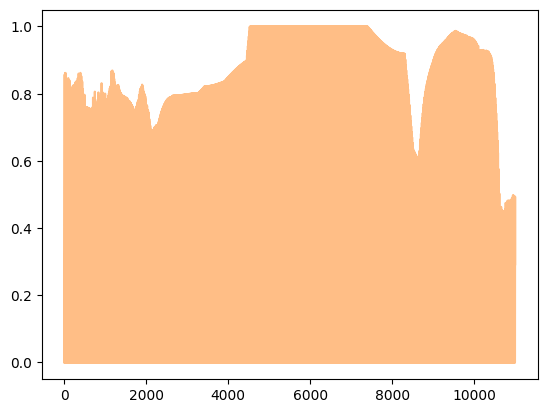

In [40]:
# plot the recon error
X_hat = reg.predict(X)
plt.plot(X_hat[0].detach().numpy())
plt.plot(X[0].detach().numpy(), alpha=0.5)


In [41]:
#

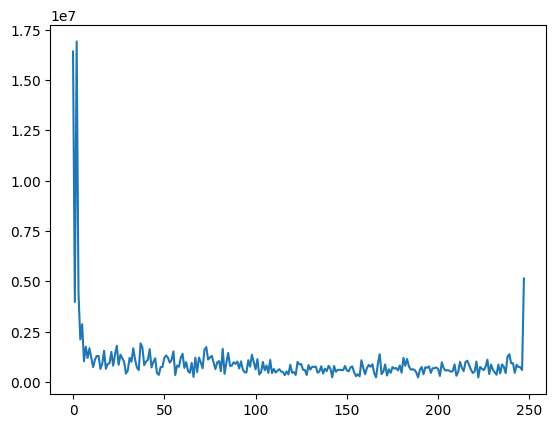

In [42]:
plt.plot(reg.losses)

In [43]:
# pass the data through the model
X_prime_hat = reg.predict(X_prime)
X_prime_hat = X_prime_hat.detach().numpy()
X_prime_hat.shape, X_prime.shape

((60, 11000), torch.Size([60, 11000]))

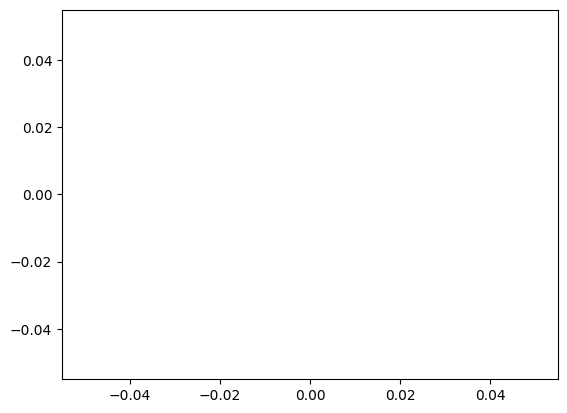

In [44]:
# get the encoded latent space and plot
X_encoded = reg.estimator.encode(X)[0].detach().numpy()
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=Y[:,0], marker='*')
# plot X_prime_hat as red dots
plt.scatter(X_prime_hat[:,0], X_prime_hat[:,1], marker='o', alpha=0.5)

In [37]:
import plotly.express as px
# cmap is red to blue
# encoded_df 
Edf = pd.DataFrame(X_encoded[:, 0:2], columns=['x1', 'x2'])
Edf['Pain_Cohort'] = Y[:,0]
Edf['Eaton_Litter'] = Y[:,1]
# make the pain cohort categorical
Edf['Pain_Cohort'] = Edf['Pain_Cohort'].astype('category')
# now make the pain 1 category * and 0 category o
#Edf['Pain_Cohort'] = Edf['Pain_Cohort'].apply(lambda x: '*' if x == 1 else 'o')
fig = px.scatter(Edf, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the size of the pain cohort bigger
# fig.update_traces(marker=dict(size=12,
#                                 line=dict(width=2,
#                                             color='DarkSlateGrey')),
#                     selector=dict(mode='markers', symbol='*')) 
# # make the markers bigger with nicer backgrounds
fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
# we want to really emphasize the Pain Cohort == 1 group. lets make the marker size much larger
fig.update_traces(marker=dict(size=209,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers', symbol='o'))
# make the figure larger and have a square aspect ratio
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue",
)
# add the X_prime_hat as red dots
# color the using Y_prime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=X_prime_hat[:,0],
        y=X_prime_hat[:,1],
        mode="markers",
        marker=dict(
            color=Y_prime[:,0],
            size=12,
            line=dict(
                color='Red',
                width=2
            )
        ),
        name="X_prime_hat"
    )
)


fig.show()
# save as latent space.html
fig.write_html("latent_space.html")

In [ ]:
reg.estimator
# get the number of learnable parameters
sum(p.numel() for p in reg.estimator.parameters() if p.requires_grad)

2252204

In [ ]:
# plot the predictions of X_prime
pred  = reg.predict(X_prime)
pred = pred.detach().numpy()

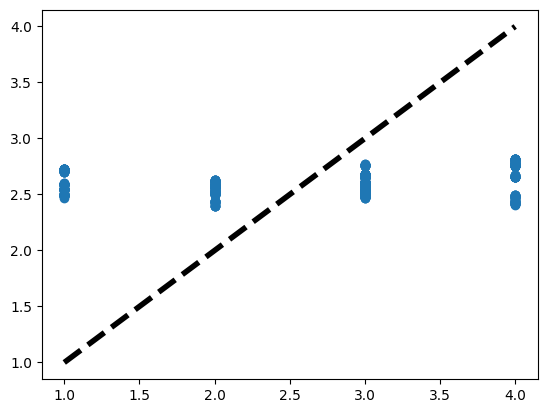

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_encoded, Y[:,1])
reg.score(X_encoded, Y[:,1])
# plot the parity
plt.scatter(Y[:,1], reg.predict(X_encoded))
# parity line
plt.plot([Y[:,1].min(), Y[:,1].max()], [Y[:,1].min(), Y[:,1].max()], 'k--', lw=4)


In [ ]:
pred = reg.estimator(X)[0].detach().numpy()
plt.plot(pred[0:10])
plt.plot(X[0:10], alpha=0.2)

 ...]

Error in callback <function _draw_all_if_interactive at 0x000001D3BE369990> (for post_execute):


KeyboardInterrupt: 

KeyboardInterrupt: 

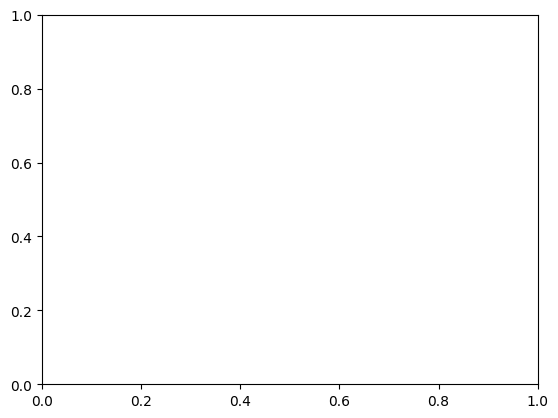

In [ ]:
plt.scatter(X.reshape(-1, 1), pred.reshape(-1, 1), edgecolors='k', alpha=0.2)
from sklearn.metrics import r2_score
r2_score(X.reshape(-1, 1), pred.reshape(-1, 1))